<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/experiments/VAE/LSTM_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
https://github.com/bayeslabs/genmol/blob/master/genmol/vae/data.py

https://github.com/aspuru-guzik-group/selfies/blob/master/examples/vae_example/chemistry_vae.py

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
! pip install PyTDC --quiet
! pip install selfies --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 2.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.4/29.4 MB 56.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 33.2 MB/s eta 0:00:00


In [2]:
from tdc.generation import MolGen
import selfies as sf
from tqdm import tqdm
data = MolGen(name = 'ZINC')
split = data.get_split()
train = split['train']
valid = split['valid']
test = split['test']

Downloading...
100%|██████████| 11.8M/11.8M [00:16<00:00, 711kiB/s] 
Loading...
Done!


In [ ]:
type(train)

pandas.core.frame.DataFrame

In [ ]:
small_smiles = []
for benzene in tqdm(train['smiles']):
    try:
        benzene_sf = sf.encoder(benzene)  # [C][=C][C][=C][C][=C][Ring1][=Branch1]
        benzene_smi = sf.decoder(benzene_sf)  # C1=CC=CC=C1
        length = sf.len_selfies(benzene_sf)  # 8
        if length < 20:
            small_smiles.append(benzene)
    except sf.EncoderError:
        pass  # sf.encoder error!
    except sf.DecoderError:
        pass  # sf.decoder error!

alphabet= sf.get_alphabet_from_selfies(small_smiles)
alphabet.add("[nop]", '[bos]', '[eos]', '[unk]')
len(alphabet)

    # symbols_benzene = list(sf.split_selfies(benzene_sf))

100%|██████████| 174618/174618 [03:23<00:00, 858.89it/s]


In [9]:
import torch

chars = set()
for string in train['smiles']:
    chars.update(string)
all_sys = ['<pad>', '<bos>', '<eos>', '<unk>'] +  sorted(list(chars))
vocab = all_sys
c2i = {c: i for i, c in enumerate(all_sys)}
i2c = {i: c for i, c in enumerate(all_sys)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vector = torch.eye(len(c2i))


In [10]:
c2i

{'<pad>': 0,
 '<bos>': 1,
 '<eos>': 2,
 '<unk>': 3,
 '#': 4,
 '(': 5,
 ')': 6,
 '+': 7,
 '-': 8,
 '/': 9,
 '1': 10,
 '2': 11,
 '3': 12,
 '4': 13,
 '5': 14,
 '6': 15,
 '7': 16,
 '8': 17,
 '=': 18,
 '@': 19,
 'B': 20,
 'C': 21,
 'F': 22,
 'H': 23,
 'I': 24,
 'N': 25,
 'O': 26,
 'P': 27,
 'S': 28,
 '[': 29,
 '\\': 30,
 ']': 31,
 'c': 32,
 'l': 33,
 'n': 34,
 'o': 35,
 'r': 36,
 's': 37}

In [12]:
def char2id(char):
    if char not in c2i:
        return c2i['<unk>']
    else:
        return c2i[char]


def id2char(id):
    if id not in i2c:
        return i2c[32]
    else:
        return i2c[id]

def string2ids(string,add_bos=False, add_eos=False):
    ids = [char2id(c) for c in string]
    if add_bos:
        ids = [c2i['<bos>']] + ids
    if add_eos:
        ids = ids + [c2i['<eos>']]
    return ids
def ids2string(ids, rem_bos=True, rem_eos=True):
    if len(ids) == 0:
        return ''
    if rem_bos and ids[0] == c2i['<bos>']:
        ids = ids[1:]
    if rem_eos and ids[-1] == c2i['<eos>']:
        ids = ids[:-1]
    string = ''.join([id2char(id) for id in ids])
    return string
def string2tensor(string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,
                          device=device if device == 'model' else device)
    return tensor
tensor = [string2tensor(string, device=device) for string in train['smiles']]
vector = torch.eye(len(c2i))  # (alphabet_len, alphabet_len)

In [13]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F

q_bidir = True
q_d_h = 256
q_n_layers = 1
q_dropout = 0.5
d_n_layers = 3
d_dropout = 0
d_z = 128
d_d_h = 512
# from data import *
class VAE(nn.Module):
  def __init__(self,vocab,vector):
    super().__init__()
    self.vocabulary = vocab
    self.vector = vector

    n_vocab, d_emb = len(vocab), vector.size(1)
    self.x_emb = nn.Embedding(n_vocab, d_emb, c2i['<pad>'])
    self.x_emb.weight.data.copy_(vector)

    #ENCODER

    self.encoder_rnn = nn.GRU(d_emb,q_d_h,num_layers=q_n_layers,
                              batch_first=True,dropout=q_dropout \
                              if q_n_layers > 1 else 0,bidirectional=q_bidir)
    q_d_last = q_d_h * (2 if q_bidir else 1)
    self.q_mu = nn.Linear(q_d_last, d_z)
    self.q_logvar = nn.Linear(q_d_last, d_z)



    # Decoder
    self.decoder_rnn = nn.GRU(d_emb + d_z,d_d_h,num_layers=d_n_layers,
                              batch_first=True,dropout=d_dropout \
                              if d_n_layers > 1 else 0)
    self.decoder_latent = nn.Linear(d_z, d_d_h)
    self.decoder_fullyc = nn.Linear(d_d_h, n_vocab)



    # Grouping the model's parameters
    self.encoder = nn.ModuleList([self.encoder_rnn,self.q_mu,self.q_logvar])
    self.decoder = nn.ModuleList([self.decoder_rnn,self.decoder_latent,
                                  self.decoder_fullyc])
    self.vae = nn.ModuleList([self.x_emb,self.encoder,self.decoder])


  @property
  def device(self):
    return next(self.parameters()).device

  def string2tensor(self, string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,
                          device=self.device if device == 'model' else device)
    return tensor

  def tensor2string(self, tensor):
    ids = tensor.tolist()
    string = ids2string(ids, rem_bos=True, rem_eos=True)
    return string

  def forward(self,x):
    z, kl_loss = self.forward_encoder(x)
    recon_loss = self.forward_decoder(x, z)
    # print("forward")
    return kl_loss, recon_loss

  def forward_encoder(self,x):
    x = [self.x_emb(i_x) for i_x in x]
    x = nn.utils.rnn.pack_sequence(x)
    _, h = self.encoder_rnn(x, None)
    h = h[-(1 + int(self.encoder_rnn.bidirectional)):]
    h = torch.cat(h.split(1), dim=-1).squeeze(0)
    mu, logvar = self.q_mu(h), self.q_logvar(h)
    eps = torch.randn_like(mu)
    z = mu + (logvar / 2).exp() * eps
    kl_loss = 0.5 * (logvar.exp() + mu ** 2 - 1 - logvar).sum(1).mean()
    return z, kl_loss

  def forward_decoder(self,x, z):
    lengths = [len(i_x) for i_x in x]
    x = nn.utils.rnn.pad_sequence(x, batch_first=True,
                                  padding_value= c2i['<pad>'])
    x_emb = self.x_emb(x)
    z_0 = z.unsqueeze(1).repeat(1, x_emb.size(1), 1)
    x_input = torch.cat([x_emb, z_0], dim=-1)
    x_input = nn.utils.rnn.pack_padded_sequence(x_input, lengths,
                                                batch_first=True)
    h_0 = self.decoder_latent(z)
    h_0 = h_0.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
    output, _ = self.decoder_rnn(x_input, h_0)
    output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
    y = self.decoder_fullyc(output)

    recon_loss = F.cross_entropy(y[:, :-1].contiguous().view(-1, y.size(-1)),
                                 x[:, 1:].contiguous().view(-1),
                                 ignore_index= c2i['<pad>'])
    return recon_loss


  def sample_z_prior(self,n_batch):
    return torch.randn(n_batch,self.q_mu.out_features,
                       device=self.x_emb.weight.device)

  def sample(self,n_batch, max_len=100, z=None, temp=1.0):
    with torch.no_grad():
      if z is None:
        z = self.sample_z_prior(n_batch)
        z = z.to(self.device)
        z_0 = z.unsqueeze(1)
        h = self.decoder_latent(z)
        h = h.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
        w = torch.tensor(c2i['<bos>'], device=self.device).repeat(n_batch)
        x = torch.tensor([c2i['<pad>']], device=device).repeat(n_batch, max_len)
        x[:, 0] = c2i['<bos>']
        end_pads = torch.tensor([max_len], device=self.device).repeat(n_batch)
        eos_mask = torch.zeros(n_batch, dtype=torch.uint8, device=self.device)


        for i in range(1, max_len):
          x_emb = self.x_emb(w).unsqueeze(1)
          x_input = torch.cat([x_emb, z_0], dim=-1)

          o, h = self.decoder_rnn(x_input, h)
          y = self.decoder_fullyc(o.squeeze(1))
          y = F.softmax(y / temp, dim=-1)

          w = torch.multinomial(y, 1)[:, 0]
          x[~eos_mask, i] = w[~eos_mask]
          i_eos_mask = ~eos_mask & (w == c2i['<eos>'])
          end_pads[i_eos_mask] = i + 1
          eos_mask = eos_mask | i_eos_mask


          new_x = []
          for i in range(x.size(0)):
            new_x.append(x[i, :end_pads[i]])


    return [self.tensor2string(i_x) for i_x in new_x]

In [39]:
# -*- coding: utf-8 -*-
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import math
import numpy as np
from collections import UserList, defaultdict
n_last = 1000
n_batch = 218
kl_start = 0
kl_w_start = 0.0
kl_w_end = 1.0
n_epoch = 500
n_workers = 0

clip_grad  = 50
lr_start = 0.003
lr_n_period = 10
lr_n_mult = 1
lr_end = 3 * 1e-5
lr_n_restarts = 6

# from data import *

def _n_epoch():
    return sum(lr_n_period * (lr_n_mult ** i) for i in range(lr_n_restarts))

def _train_epoch(model, epoch, train_loader, kl_weight, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    kl_loss_values = CircularBuffer(n_last)
    recon_loss_values = CircularBuffer(n_last)
    loss_values = CircularBuffer(n_last)

    for i, input_batch in tqdm(enumerate(train_loader),
                               total=len(train_loader)):
        input_batch = tuple(data.to(device) for data in input_batch)

    #forward
        kl_loss, recon_loss = model(input_batch)
        loss = kl_weight * kl_loss + recon_loss
    #backward
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(get_optim_params(model), clip_grad)
            optimizer.step()

        kl_loss_values.add(kl_loss.item())
        recon_loss_values.add(recon_loss.item())
        loss_values.add(loss.item())
        lr = (optimizer.param_groups[0]['lr'] \
              if optimizer is not None else None)

    #update train_loader
        kl_loss_value = kl_loss_values.mean()
        recon_loss_value = recon_loss_values.mean()
        loss_value = loss_values.mean()
        postfix = [f'loss={loss_value:.5f}',f'(kl={kl_loss_value:.5f}',
                   f'recon={recon_loss_value:.5f})',
                   f'klw={kl_weight:.5f} lr={lr:.5f}']

        if i % (len(train_loader)/3) == 0 and i!= 0:
            print(f'Epoch {epoch}: {i}/{len(train_loader)} |', postfix)
    postfix = {'epoch': epoch,'kl_weight': kl_weight,'lr': lr,
               'kl_loss': kl_loss_value,'recon_loss': recon_loss_value,
               'loss': loss_value, 'mode': 'Eval'\
               if optimizer is None else 'Train'}
    model.eval()
    sample_smis = sample.take_samples(model, n_batch)
    valid_rate = visual_mols(sample_smis)

    # if valid_rate > max_valid:
    #     max_valid = valid_rate
    #     import os
    #     if not os.path.exists('ckpt/'): os.makedirs('ckpt/')
    #     model_path = f'ckpt/epoch_{epoch}'

    if optimizer is not None: model.train()
    return postfix

def _train(model, train_loader, val_loader=None, logger=None):
    optimizer = optim.Adam(get_optim_params(model),lr= lr_start)

    lr_annealer = CosineAnnealingLRWithRestart(optimizer)

    model.zero_grad()
    for epoch in range(n_epoch):

        kl_annealer = KLAnnealer(n_epoch)
        kl_weight = kl_annealer(epoch)
        postfix = _train_epoch(model, epoch, train_loader, kl_weight, optimizer)
        lr_annealer.step()

def fit(model, train_data, val_data=None):
    logger = Logger() if False is not None else None
    train_loader = get_dataloader(model, train_data, shuffle=True)


    val_loader = None if val_data is None else \
                get_dataloader(model, val_data, shuffle=False)
    _train(model, train_loader, val_loader, logger)
    return model

def get_collate_device(model): return model.device
def get_dataloader(model, train_data, collate_fn=None, shuffle=True):
    if collate_fn is None:
        collate_fn = get_collate_fn(model)
        print(collate_fn)
    return DataLoader(train_data, batch_size=n_batch, shuffle=shuffle,
                      num_workers=n_workers, collate_fn=collate_fn)

def get_collate_fn(model):
    device = get_collate_device(model)

    def collate(train_data):
        train_data.sort(key=len, reverse=True)
        tensors = [string2tensor(string, device=device) for string in train_data]
        return tensors

    return collate

def get_optim_params(model):
    return (p for p in model.parameters() if p.requires_grad)

class KLAnnealer:
    def __init__(self,n_epoch):
        self.i_start = kl_start
        self.w_start = kl_w_start
        self.w_max = kl_w_end
        self.n_epoch = n_epoch


        self.inc = (self.w_max - self.w_start) / (self.n_epoch - self.i_start)

    def __call__(self, i):
        k = (i - self.i_start) if i >= self.i_start else 0
        return self.w_start + k * self.inc



class CosineAnnealingLRWithRestart(_LRScheduler):
    def __init__(self , optimizer):
        self.n_period = lr_n_period
        self.n_mult = lr_n_mult
        self.lr_end = lr_end

        self.current_epoch = 0
        self.t_end = self.n_period

        # Also calls first epoch
        super().__init__(optimizer, -1)

    def get_lr(self):
        return [self.lr_end + (base_lr - self.lr_end) *
                (1 + math.cos(math.pi * self.current_epoch / self.t_end)) / 2
                for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

        if self.current_epoch == self.t_end:
            self.current_epoch = 0
            self.t_end = self.n_mult * self.t_end

class CircularBuffer:
    def __init__(self, size):
        self.max_size = size
        self.data = np.zeros(self.max_size)
        self.size = 0
        self.pointer = -1

    def add(self, element):
        self.size = min(self.size + 1, self.max_size)
        self.pointer = (self.pointer + 1) % self.max_size
        self.data[self.pointer] = element
        return element

    def last(self):
        assert self.pointer != -1, "Can't get an element from an empty buffer!"
        return self.data[self.pointer]

    def mean(self):
        return self.data.mean()


class Logger(UserList):
    def __init__(self, data=None):
        super().__init__()
        self.sdata = defaultdict(list)
        for step in (data or []):
            self.append(step)

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.data[key]
        elif isinstance(key, slice):
            return Logger(self.data[key])
        else:
            ldata = self.sdata[key]
            if isinstance(ldata[0], dict):
                return Logger(ldata)
            else:
                return ldata

    def append(self, step_dict):
        super().append(step_dict)
        for k, v in step_dict.items():
            self.sdata[k].append(v)

In [37]:
from tqdm import tqdm
import pandas as pd
n_samples = 3000
n_jobs = 1
max_len = 100

class sample():
  def take_samples(model,n_batch):
    n = n_samples
    samples = []
    with tqdm(total=n_samples, desc='Generating samples') as T:
      while n > 0:
        current_samples = model.sample(min(n, n_batch), max_len)
        samples.extend(current_samples)
        n -= len(current_samples)
        T.update(len(current_samples))
    samples = pd.DataFrame(samples, columns=['SMILES'])
    return samples

def visual_mols(sample_smis):
    from IPython.display import display
    from rdkit import Chem
    from rdkit import RDLogger
    RDLogger.DisableLog('rdApp.*')

    m = Chem.MolFromSmiles
    valid_smis = []
    for i in sample_smis.SMILES:
        try:
            mol = m(i)
            if mol != None: valid_smis.append(i)
        except: pass
    valid_rate = len(valid_smis) / len(sample_smis)
    unique_smis = [*set(valid_smis)]
    unique_rate = len(unique_smis) / len(sample_smis)

    print(f'valid {valid_rate*100:.3f}%  |  unique {unique_rate*100:.3f}%')

    from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

    MAX_GRID = 16
    img = MolsToGridImage(
        [m(smi) for smi in unique_smis[:MAX_GRID]],
        molsPerRow=int(math.sqrt(MAX_GRID)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)
    return valid_rate




<function get_collate_fn.<locals>.collate at 0x7f82ae550a60>
<function get_collate_fn.<locals>.collate at 0x7f82ae2148b0>


 34%|███▎      | 269/801 [00:44<01:31,  5.84it/s]

Epoch 0: 267/801 | ['loss=0.49659', '(kl=53.56766', 'recon=0.49659)', 'klw=0.00000 lr=0.00293']


 67%|██████▋   | 536/801 [01:28<00:43,  6.12it/s]

Epoch 0: 534/801 | ['loss=0.67122', '(kl=156.75129', 'recon=0.67122)', 'klw=0.00000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 358.59it/s]

valid 8.333%  |  unique 7.400%


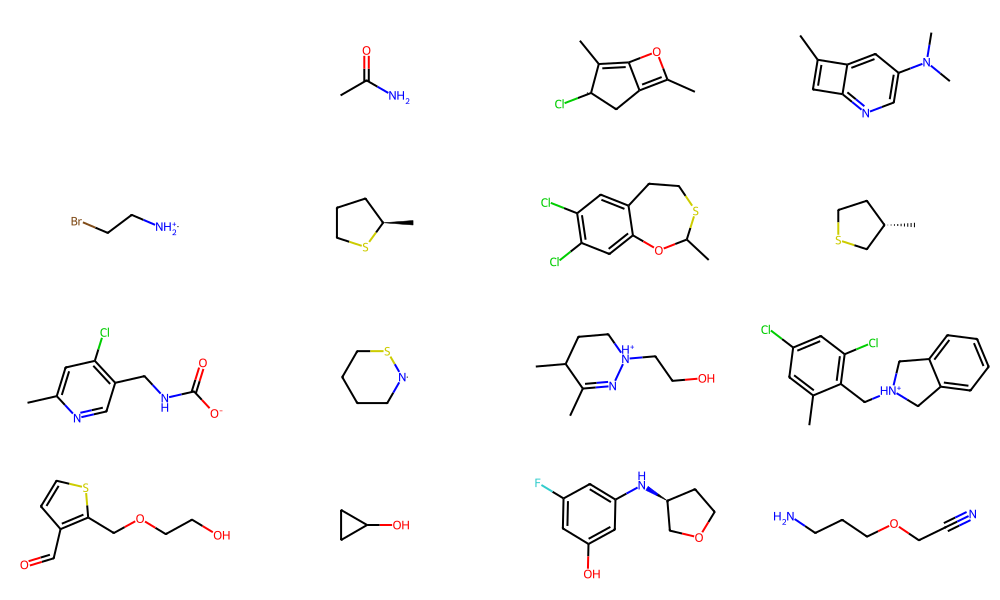

 34%|███▎      | 269/801 [00:43<01:24,  6.28it/s]

Epoch 1: 267/801 | ['loss=0.13093', '(kl=18.52459', 'recon=0.09388)', 'klw=0.00200 lr=0.00272']


 67%|██████▋   | 536/801 [01:27<00:43,  6.11it/s]

Epoch 1: 534/801 | ['loss=0.23016', '(kl=33.74478', 'recon=0.16267)', 'klw=0.00200 lr=0.00272']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 359.91it/s]


valid 24.400%  |  unique 24.400%


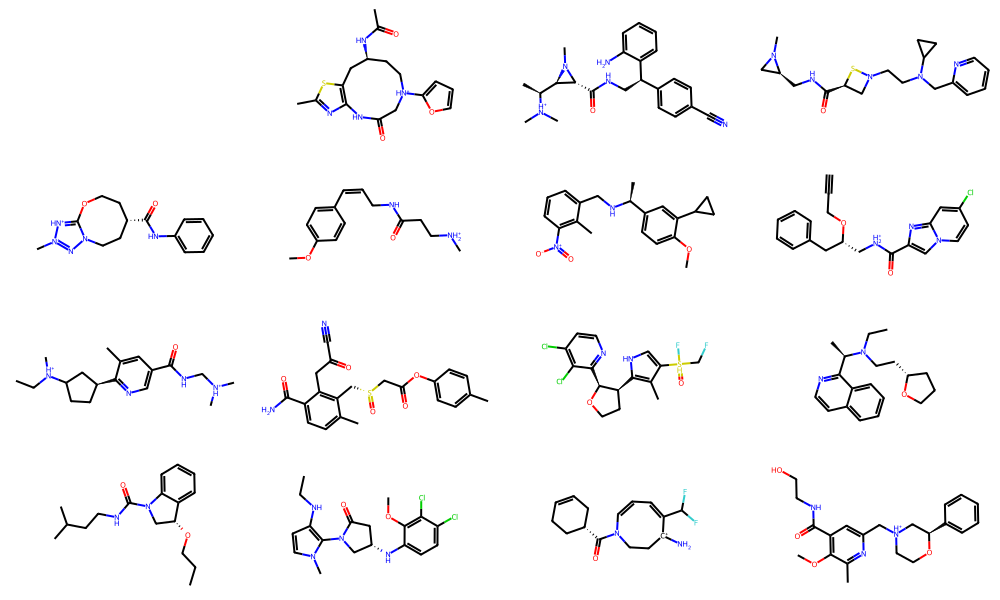

 34%|███▎      | 269/801 [00:43<01:26,  6.17it/s]

Epoch 2: 267/801 | ['loss=0.10051', '(kl=11.35531', 'recon=0.05509)', 'klw=0.00400 lr=0.00239']


 67%|██████▋   | 536/801 [01:27<00:43,  6.04it/s]

Epoch 2: 534/801 | ['loss=0.19536', '(kl=22.33273', 'recon=0.10603)', 'klw=0.00400 lr=0.00239']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 362.63it/s]


valid 36.967%  |  unique 36.967%


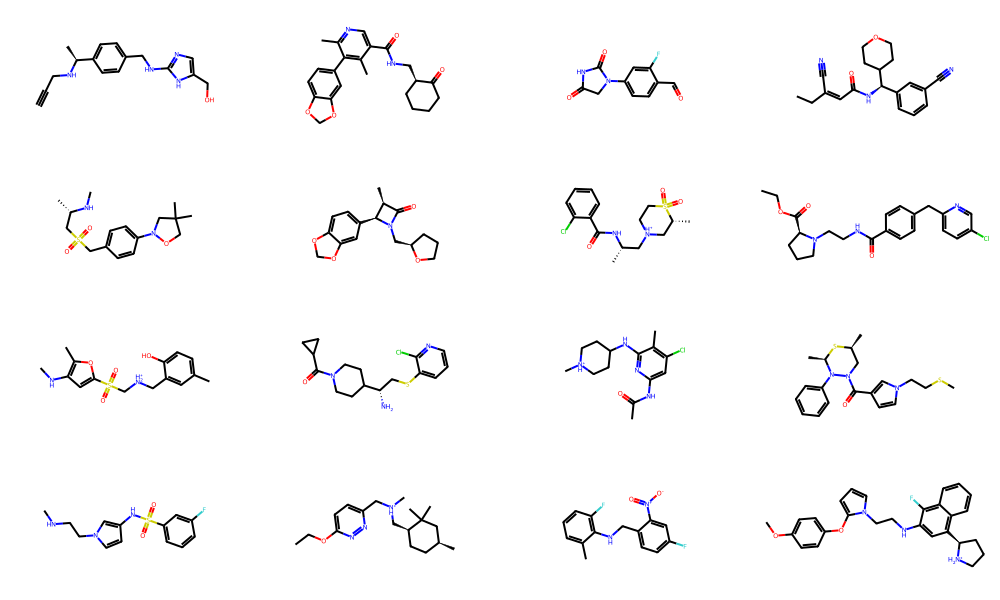

 34%|███▎      | 269/801 [00:43<01:26,  6.16it/s]

Epoch 3: 267/801 | ['loss=0.10622', '(kl=9.32689', 'recon=0.05026)', 'klw=0.00600 lr=0.00197']


 67%|██████▋   | 536/801 [01:27<00:43,  6.12it/s]

Epoch 3: 534/801 | ['loss=0.21007', '(kl=18.44259', 'recon=0.09942)', 'klw=0.00600 lr=0.00197']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 359.40it/s]


valid 51.800%  |  unique 51.800%


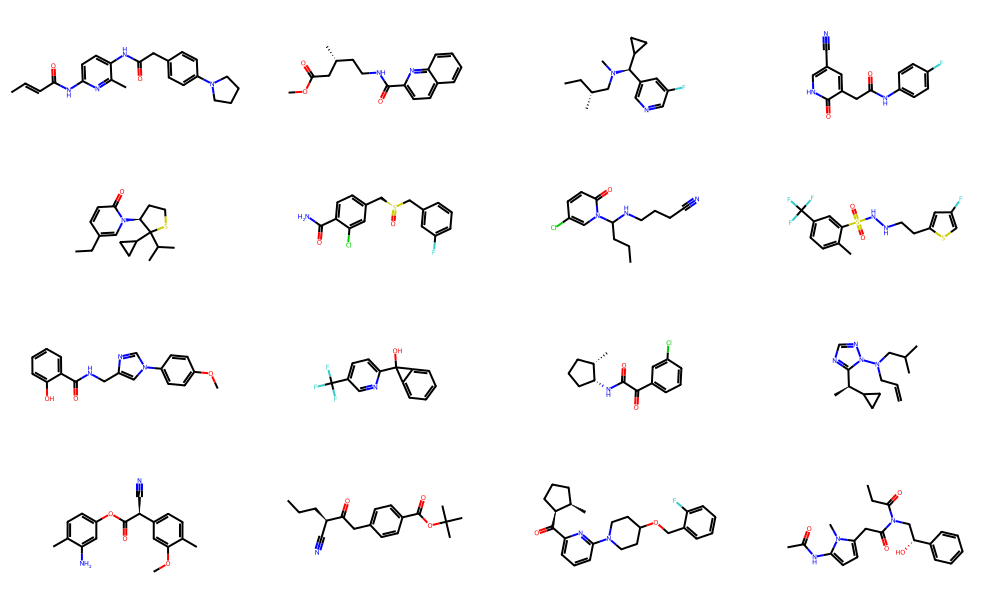

 34%|███▎      | 269/801 [00:43<01:27,  6.11it/s]

Epoch 4: 267/801 | ['loss=0.11512', '(kl=8.00653', 'recon=0.05107)', 'klw=0.00800 lr=0.00152']


 67%|██████▋   | 536/801 [01:27<00:43,  6.10it/s]

Epoch 4: 534/801 | ['loss=0.22836', '(kl=15.83358', 'recon=0.10169)', 'klw=0.00800 lr=0.00152']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 363.23it/s]


valid 63.967%  |  unique 63.967%


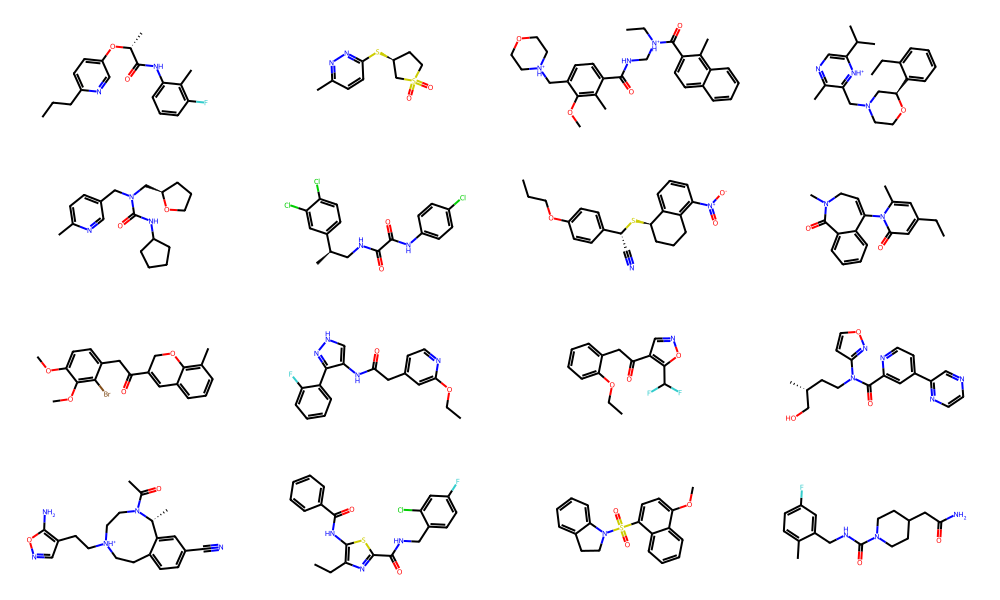

 34%|███▎      | 269/801 [00:43<01:27,  6.06it/s]

Epoch 5: 267/801 | ['loss=0.12307', '(kl=6.96501', 'recon=0.05342)', 'klw=0.01000 lr=0.00106']


 67%|██████▋   | 536/801 [01:27<00:42,  6.22it/s]

Epoch 5: 534/801 | ['loss=0.24469', '(kl=13.77847', 'recon=0.10690)', 'klw=0.01000 lr=0.00106']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 366.71it/s]


valid 68.467%  |  unique 68.467%


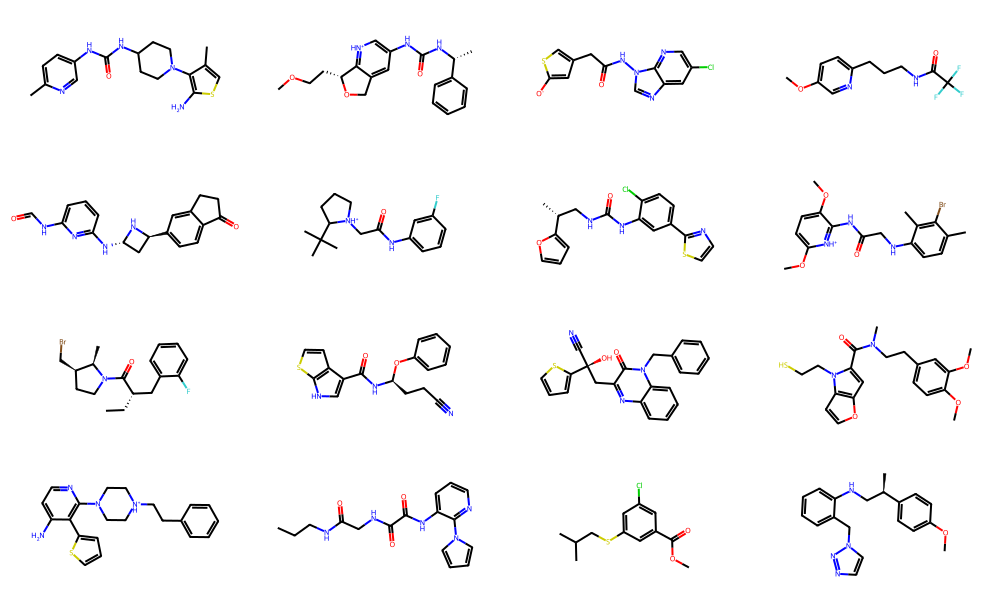

 34%|███▎      | 269/801 [00:43<01:25,  6.26it/s]

Epoch 6: 267/801 | ['loss=0.13033', '(kl=6.12662', 'recon=0.05681)', 'klw=0.01200 lr=0.00064']


 67%|██████▋   | 536/801 [01:26<00:42,  6.23it/s]

Epoch 6: 534/801 | ['loss=0.25922', '(kl=12.09649', 'recon=0.11406)', 'klw=0.01200 lr=0.00064']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 369.22it/s]


valid 75.167%  |  unique 75.167%


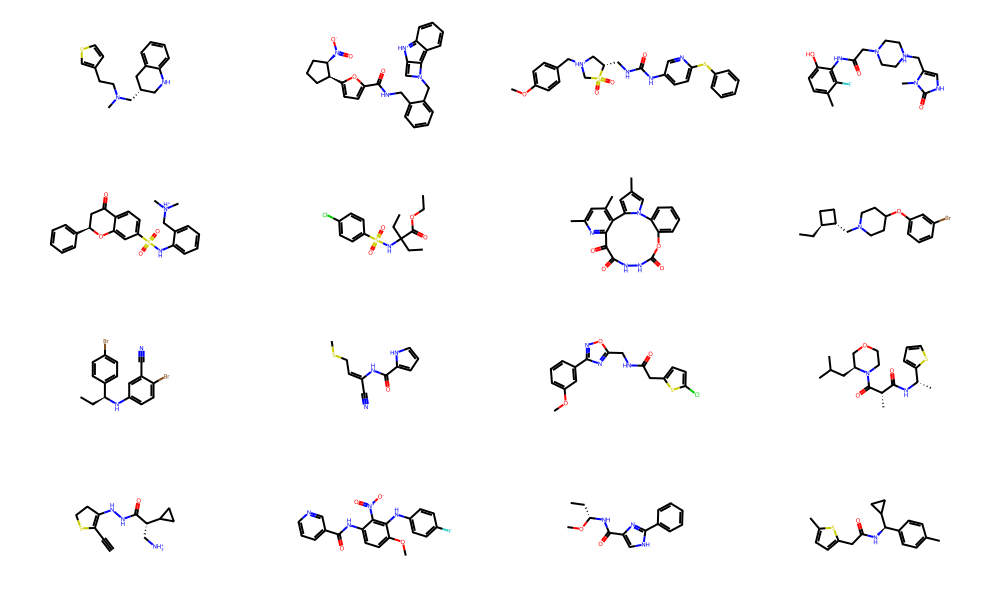

 34%|███▎      | 269/801 [00:43<01:28,  6.00it/s]

Epoch 7: 267/801 | ['loss=0.13709', '(kl=5.41342', 'recon=0.06130)', 'klw=0.01400 lr=0.00031']


 67%|██████▋   | 536/801 [01:27<00:43,  6.14it/s]

Epoch 7: 534/801 | ['loss=0.27268', '(kl=10.68215', 'recon=0.12313)', 'klw=0.01400 lr=0.00031']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 361.71it/s]


valid 78.533%  |  unique 78.533%


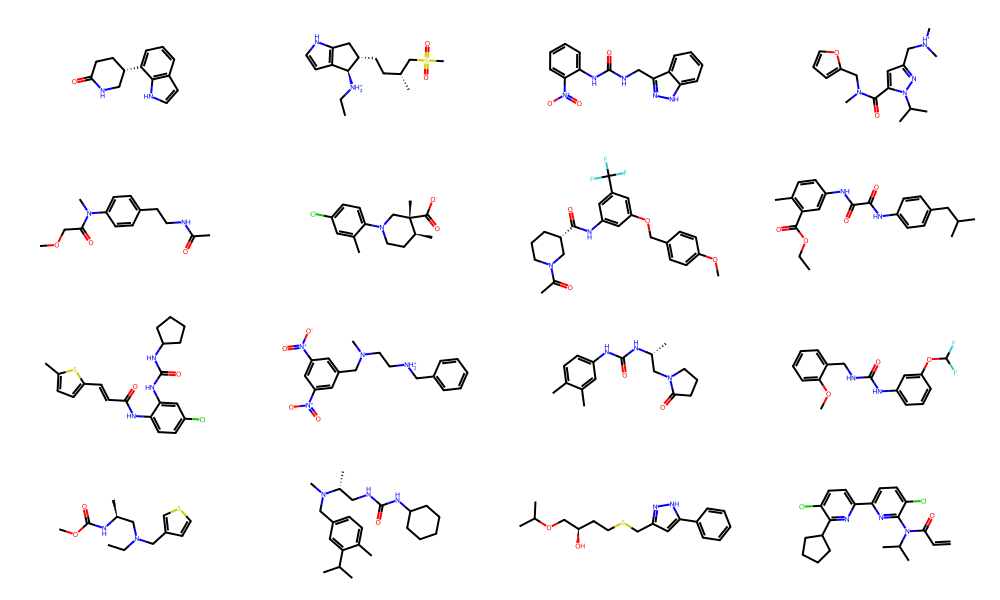

 34%|███▎      | 269/801 [00:43<01:27,  6.06it/s]

Epoch 8: 267/801 | ['loss=0.14416', '(kl=4.86299', 'recon=0.06635)', 'klw=0.01600 lr=0.00010']


 67%|██████▋   | 536/801 [01:27<00:43,  6.04it/s]

Epoch 8: 534/801 | ['loss=0.28717', '(kl=9.58942', 'recon=0.13374)', 'klw=0.01600 lr=0.00010']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 367.13it/s]


valid 80.167%  |  unique 80.167%


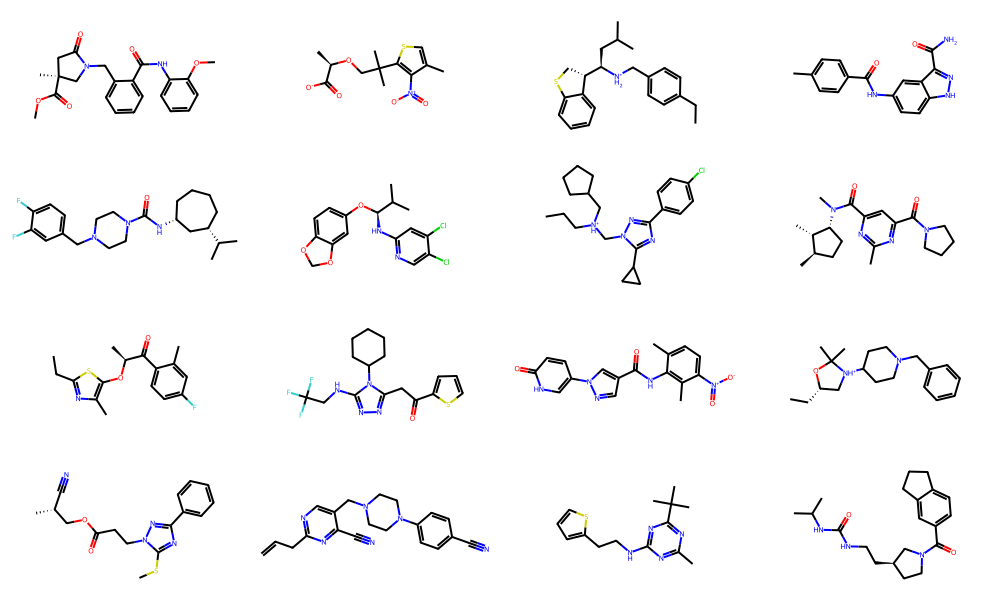

 34%|███▎      | 269/801 [00:44<01:25,  6.26it/s]

Epoch 9: 267/801 | ['loss=0.15139', '(kl=4.41786', 'recon=0.07187)', 'klw=0.01800 lr=0.00003']


 67%|██████▋   | 536/801 [01:27<00:42,  6.18it/s]

Epoch 9: 534/801 | ['loss=0.30229', '(kl=8.73656', 'recon=0.14504)', 'klw=0.01800 lr=0.00003']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 364.33it/s]


valid 79.567%  |  unique 79.533%


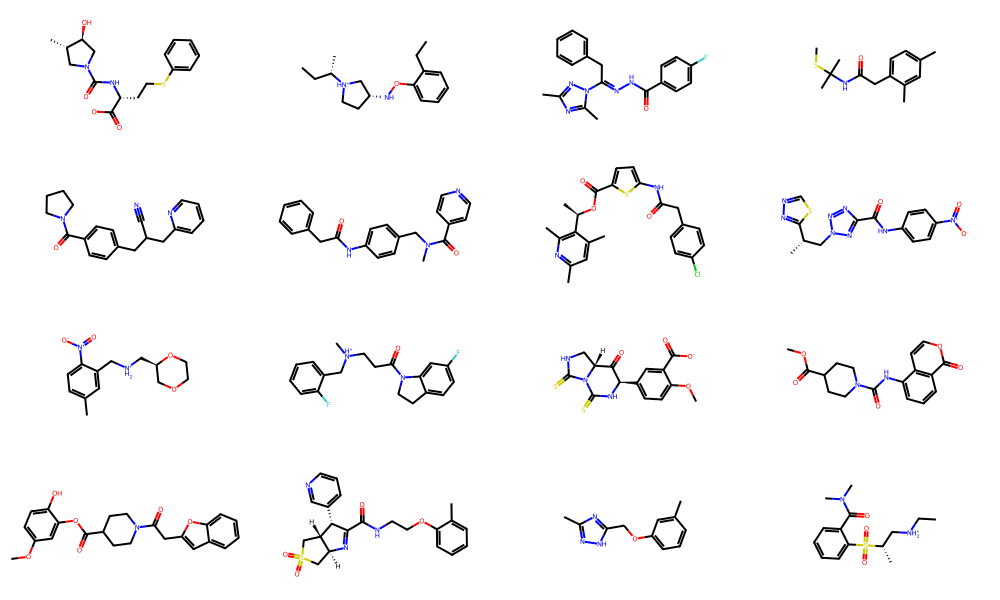

 34%|███▎      | 269/801 [00:43<01:26,  6.15it/s]

Epoch 10: 267/801 | ['loss=0.17815', '(kl=2.55490', 'recon=0.12705)', 'klw=0.02000 lr=0.00293']


 67%|██████▋   | 536/801 [01:27<00:43,  6.13it/s]

Epoch 10: 534/801 | ['loss=0.35142', '(kl=4.25124', 'recon=0.26640)', 'klw=0.02000 lr=0.00293']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 361.85it/s]


valid 70.533%  |  unique 70.533%


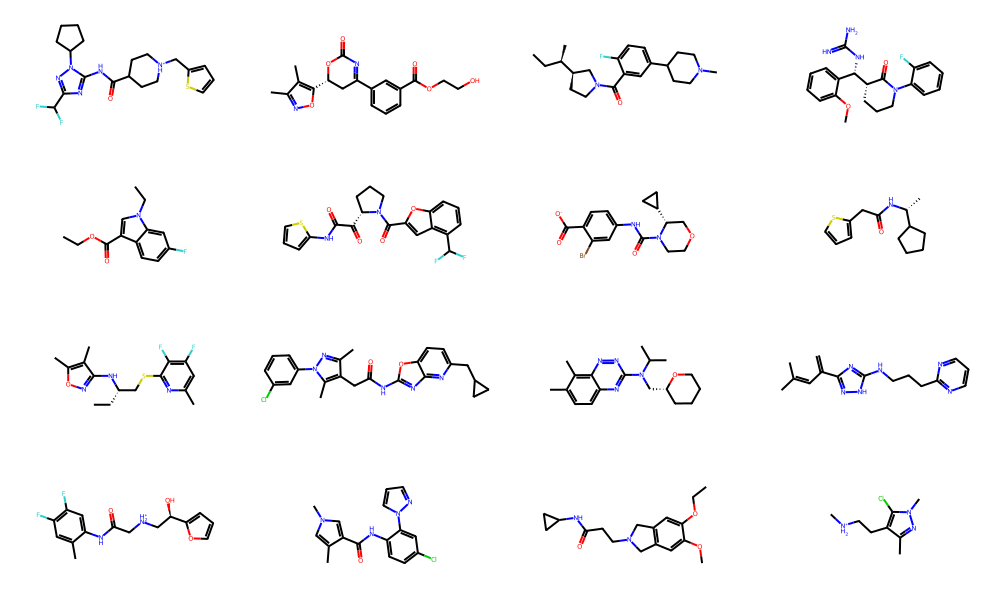

 34%|███▎      | 269/801 [00:43<01:26,  6.16it/s]

Epoch 11: 267/801 | ['loss=0.16988', '(kl=0.80298', 'recon=0.15221)', 'klw=0.02200 lr=0.00272']


 67%|██████▋   | 536/801 [01:26<00:43,  6.03it/s]

Epoch 11: 534/801 | ['loss=0.33744', '(kl=1.33804', 'recon=0.30800)', 'klw=0.02200 lr=0.00272']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 366.43it/s]


valid 71.700%  |  unique 71.700%


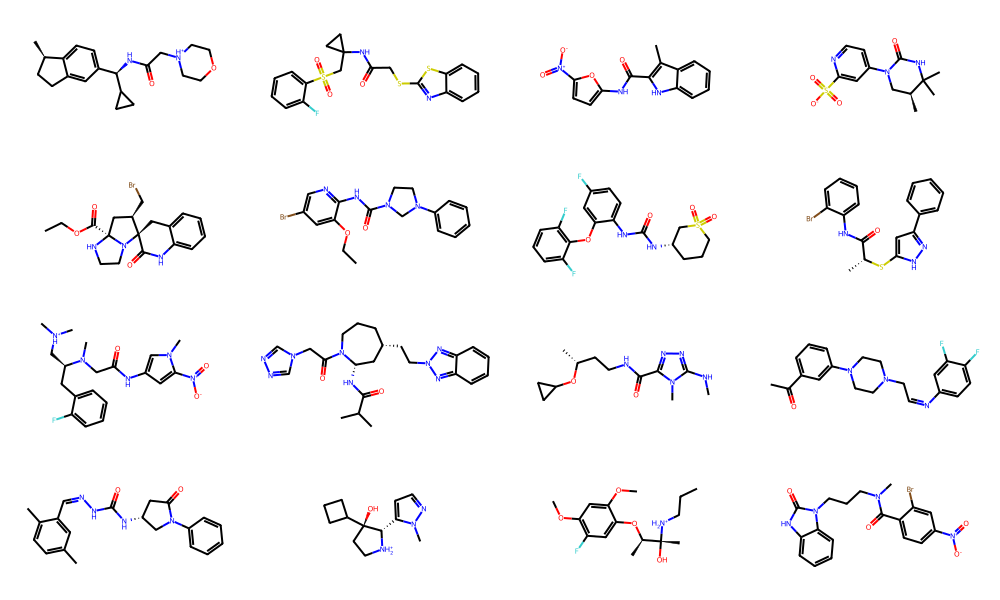

 34%|███▎      | 269/801 [00:43<01:27,  6.08it/s]

Epoch 12: 267/801 | ['loss=0.16412', '(kl=0.21194', 'recon=0.15903)', 'klw=0.02400 lr=0.00239']


 67%|██████▋   | 536/801 [01:26<00:43,  6.16it/s]

Epoch 12: 534/801 | ['loss=0.32642', '(kl=0.33730', 'recon=0.31833)', 'klw=0.02400 lr=0.00239']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 365.84it/s]


valid 74.933%  |  unique 74.933%


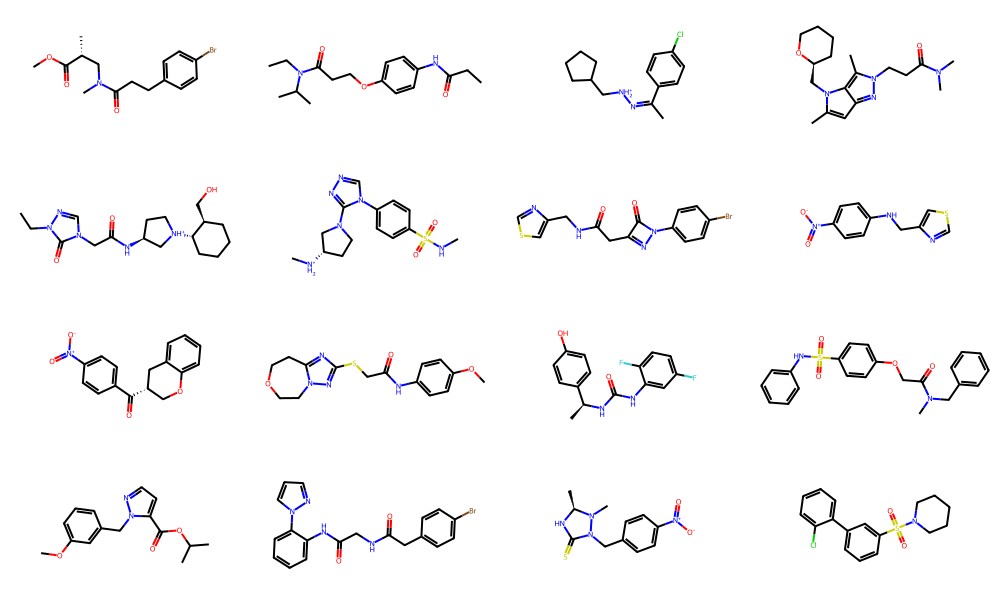

 34%|███▎      | 269/801 [00:43<01:25,  6.20it/s]

Epoch 13: 267/801 | ['loss=0.15973', '(kl=0.04955', 'recon=0.15844)', 'klw=0.02600 lr=0.00197']


 67%|██████▋   | 536/801 [01:26<00:42,  6.20it/s]

Epoch 13: 534/801 | ['loss=0.31769', '(kl=0.08386', 'recon=0.31551)', 'klw=0.02600 lr=0.00197']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 365.36it/s]


valid 80.467%  |  unique 80.467%


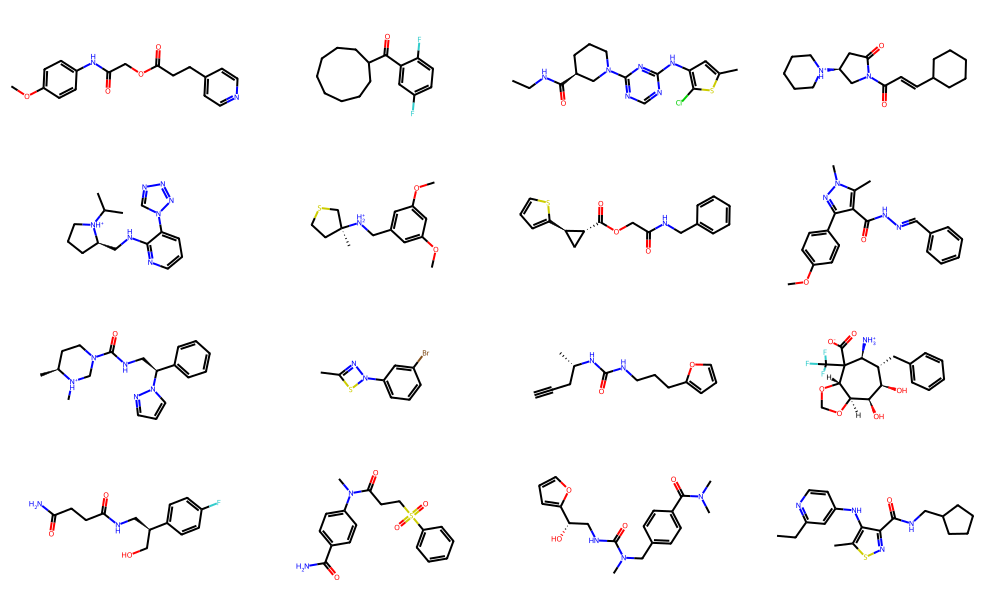

 34%|███▎      | 269/801 [00:43<01:24,  6.27it/s]

Epoch 14: 267/801 | ['loss=0.15531', '(kl=0.01846', 'recon=0.15479)', 'klw=0.02800 lr=0.00152']


 67%|██████▋   | 536/801 [01:26<00:43,  6.16it/s]

Epoch 14: 534/801 | ['loss=0.30922', '(kl=0.03278', 'recon=0.30830)', 'klw=0.02800 lr=0.00152']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 371.40it/s]


valid 83.800%  |  unique 83.800%


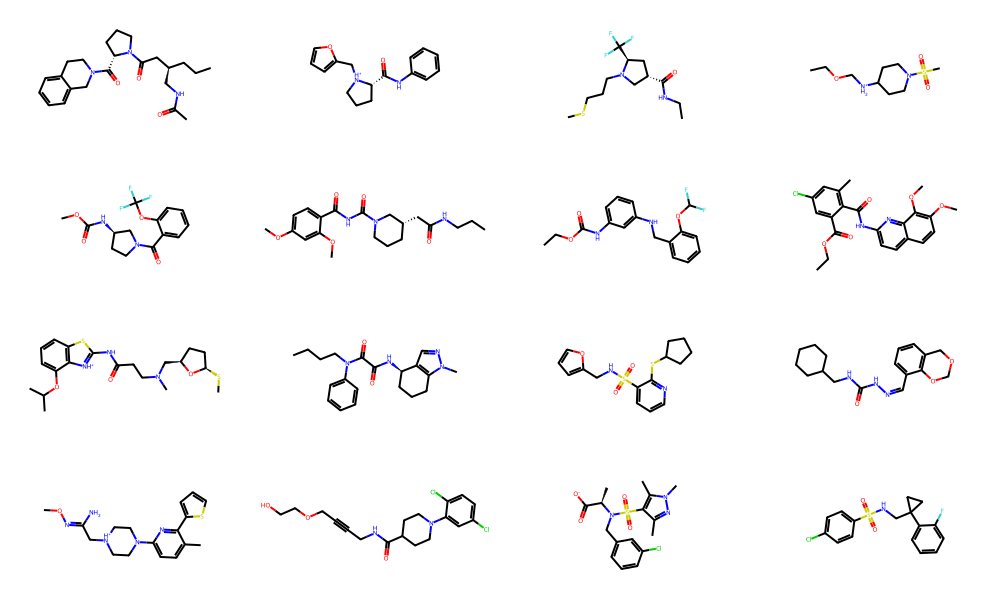

 34%|███▎      | 269/801 [00:43<01:25,  6.25it/s]

Epoch 15: 267/801 | ['loss=0.15106', '(kl=0.00918', 'recon=0.15079)', 'klw=0.03000 lr=0.00106']


 67%|██████▋   | 536/801 [01:26<00:42,  6.22it/s]

Epoch 15: 534/801 | ['loss=0.30106', '(kl=0.01739', 'recon=0.30053)', 'klw=0.03000 lr=0.00106']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 364.34it/s]


valid 87.400%  |  unique 87.400%


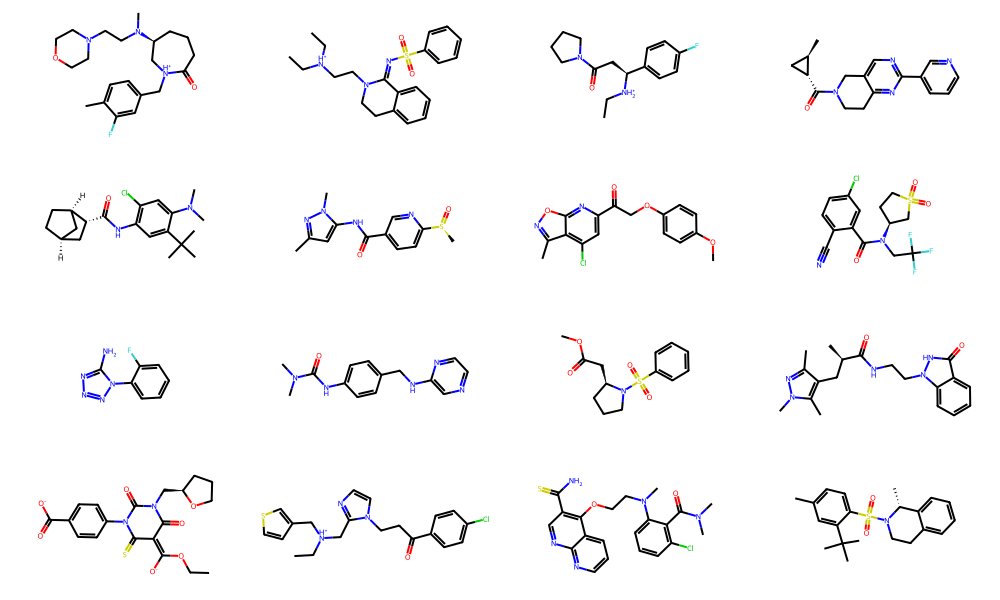

 34%|███▎      | 269/801 [00:43<01:26,  6.17it/s]

Epoch 16: 267/801 | ['loss=0.14735', '(kl=0.00560', 'recon=0.14717)', 'klw=0.03200 lr=0.00064']


 67%|██████▋   | 536/801 [01:26<00:42,  6.20it/s]

Epoch 16: 534/801 | ['loss=0.29373', '(kl=0.01050', 'recon=0.29340)', 'klw=0.03200 lr=0.00064']


Generating samples: 100%|██████████| 3000/3000 [00:08<00:00, 365.77it/s]


valid 86.733%  |  unique 86.733%


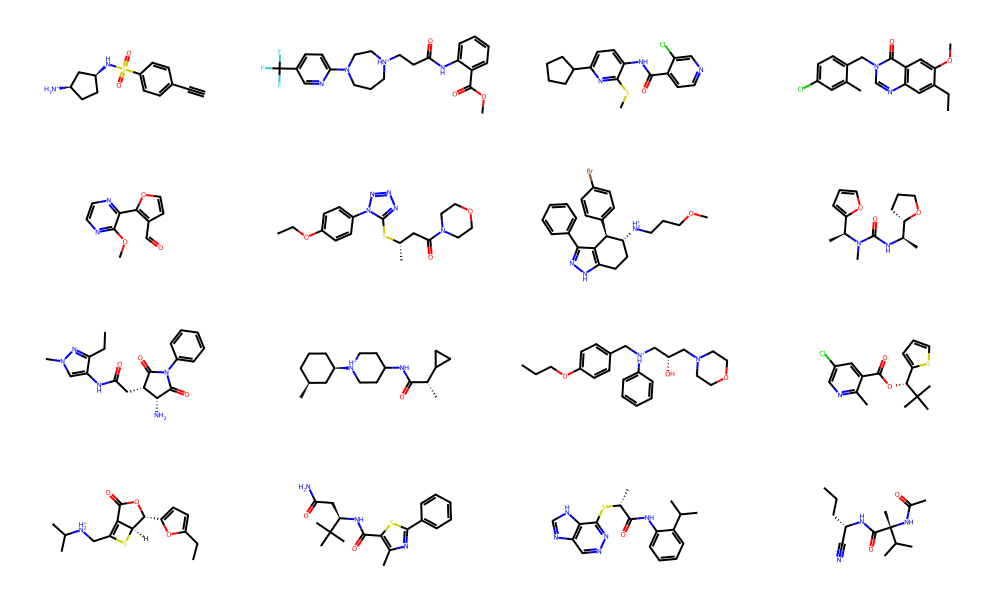

 19%|█▉        | 152/801 [00:24<01:44,  6.21it/s]

In [ ]:
model = VAE(vocab,vector).to(device)
fit(model, train['smiles'], test['smiles'])